In [1]:
import os
import csv
import sys
import json
import random
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import roc_auc_score

from collections import defaultdict

%matplotlib inline

In [2]:
sys.path.append('../src')
import plot_helpers as ph
pd.set_option('display.precision', 3)

In [3]:
experiment_id = "10F"
experiment = json.load(open('../analysis.json'))["experiments"][experiment_id]

In [4]:
from IPython.display import Markdown as md
md(f"""
## {experiment['name']}

### Description
{experiment['description']}

### Results


""")


## TAC Training/Testing Split - Boxed Warnings: PubMedBERT, refmeth 14, nwords 125, pretrained with ALL sections

### Description
Use the TAC training and testing splits instead of randomly splitting. Network used here is PubMedBERT which was found to have better performance in head-to-head comparions (See Experiments 0, 0A, 1, and 10A). Using 60 as nwords, found to have the best performance (See Experiments 2-2B and 10C). Training on ALL sections so that we can evaluate BW method on TAC gold standard.

### Results




<ipython-input-10-44d40acb40b5>:64: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2, 2, 2)
<ipython-input-10-44d40acb40b5>:64: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2, 2, 2)


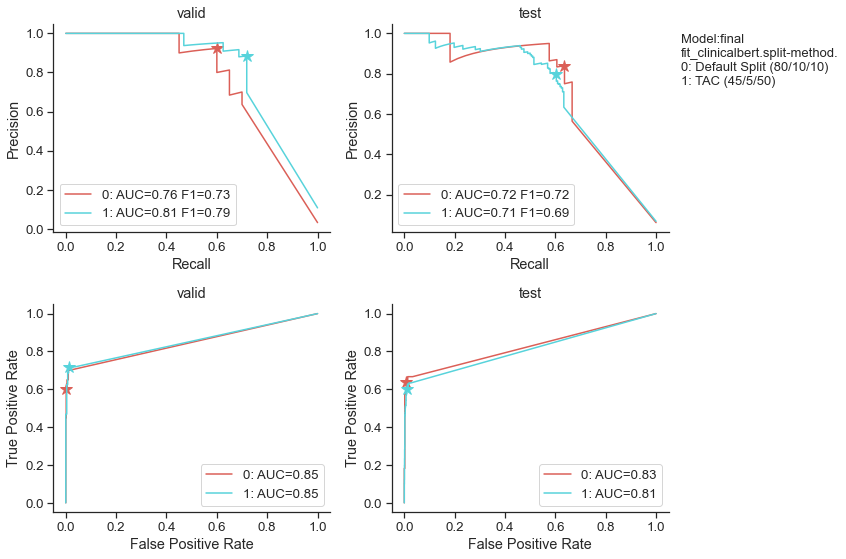

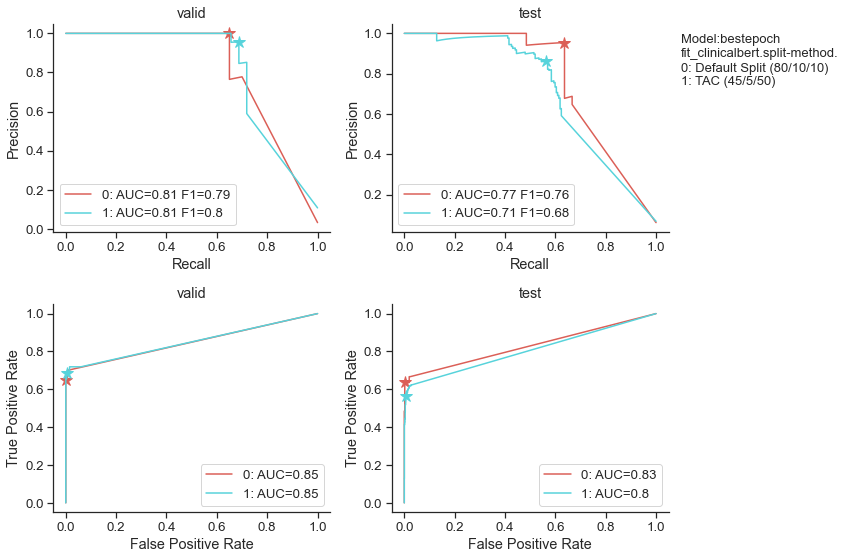

In [10]:
perfdata = defaultdict(lambda: defaultdict(list))

for modeltype in ('final', 'bestepoch'):
    resfiles = experiment[modeltype]
    colors = sns.color_palette("hls", len(resfiles))

    plt.figure(figsize=(12,8))
    plotcounter = 1


    for split in ('valid', 'test'):
        plt.subplot(2, 2, plotcounter)
        plotcounter += 1
        plt.title(split)

        for i, resfile in enumerate(resfiles):

            df = pd.read_csv(os.path.join('..', resfile), index_col=0)
            df['label'] = [1 if c == 'is_event' else 0 for c in df['class']]
            split_df = df[df['split']==split]
            # we only are focused on the perfomrnace for the Boxed Warnings examples
            #split_df = split_df[split_df['section']=='BW']
            
            prdata = ph.prdata(split_df['label'], split_df['Pred1'])
            perfdata[(modeltype, split)]['prdata'].append(prdata)
            
            plt.plot(prdata['recall'], prdata['precision'], color=colors[i], 
                     label=f'{i}: AUC={prdata["pr_auc"]:.2} F1={prdata["max_f1"]:.2}'
                    )
            plt.plot([prdata['max_f1_recall']], [prdata['max_f1_precision']], '*', color=colors[i], markersize=12)

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend()
        sns.despine()

    for split in ('valid', 'test'):
        plt.subplot(2, 2, plotcounter)
        plotcounter += 1
        plt.title(split)

        for i, resfile in enumerate(resfiles):

            df = pd.read_csv(os.path.join('..', resfile), index_col=0)
            df['label'] = [1 if c == 'is_event' else 0 for c in df['class']]
            split_df = df[df['split']==split]
            # we only are focused on the perfomrnace for the Boxed Warnings examples
            #split_df = split_df[split_df['section']=='BW']
            
            prdata = ph.prdata(split_df['label'], split_df['Pred1'])
            rocdata = ph.rocdata(split_df['label'], split_df['Pred1'], prdata['max_f1_threshold'])
            perfdata[(modeltype, split)]['rocdata'].append(rocdata)
            
            plt.plot(rocdata['fpr'], rocdata['tpr'], color=colors[i], 
                     label=f'{i}: AUC={rocdata["roc_auc"]:.2}'
                    )
            plt.plot([rocdata['max_f1_fpr']], [rocdata['max_f1_tpr']], '*', color=colors[i], markersize=12)

        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        sns.despine()

    plt.subplot(2, 2, 2)
    reflegend = f'Model:{modeltype}\n{experiment["factor"]}\n' + '\n'.join([f"{i}: {s}" for i, s in enumerate(experiment['labels'])])
    plt.text(1.1, 1.0, reflegend, fontsize=13, verticalalignment='top')
    #plt.suptitle(modeltype)
    plt.tight_layout()
    
    plt.savefig(f'../figures/Experiment{experiment_id}-{modeltype}.pdf')

2.33008086681366


,Factor,Valid Precision,Valid Recall,Valid F1,Valid AUPR,Valid AUROC,Threshold,Test Precision,Test Recall,Test F1,Test AUPR,Test AUROC
0,Default Split (80/10/10),1.000,0.650,0.788,0.810,0.849,6.12,0.955,0.636,0.764,0.767,0.829
1,TAC (45/5/50),0.957,0.688,0.800,0.811,0.850,2.33,0.864,0.564,0.683,0.712,0.804


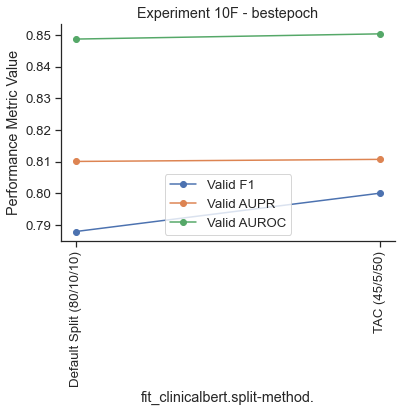

In [11]:
modeltype = 'bestepoch'
key = (modeltype, 'valid')
dfdata = {
    'Factor': experiment['labels'],
    'Valid Precision': [d['max_f1_precision'] for d in perfdata[key]['prdata']],
    'Valid Recall': [d['max_f1_recall'] for d in perfdata[key]['prdata']],
    'Valid F1': [d['max_f1'] for d in perfdata[key]['prdata']],
    'Valid AUPR': [d['pr_auc'] for d in perfdata[key]['prdata']],
    'Valid AUROC': [d['roc_auc'] for d in perfdata[key]['rocdata']],
    'Threshold': [d['max_f1_threshold'] for d in perfdata[key]['prdata']]
}

valid = pd.DataFrame(dfdata)

key = (modeltype, 'test')
dfdata = {
#     'Factor': experiment['labels'],
    'Test Precision': [d['max_f1_precision'] for d in perfdata[key]['prdata']],
    'Test Recall': [d['max_f1_recall'] for d in perfdata[key]['prdata']],
    'Test F1': [d['max_f1'] for d in perfdata[key]['prdata']],
    'Test AUPR': [d['pr_auc'] for d in perfdata[key]['prdata']],
    'Test AUROC': [d['roc_auc'] for d in perfdata[key]['rocdata']],
}

test = pd.DataFrame(dfdata)

sns.set(style='ticks', font_scale=1.2)

for col in ('Valid F1', 'Valid AUPR', 'Valid AUROC'):
    plt.plot(valid[col], 'o-', label=col)

plt.xticks(ticks = range(len(valid)), labels = valid['Factor'], rotation=90)
plt.xlabel(experiment['factor'])
plt.ylabel('Performance Metric Value')
plt.title(f"Experiment {experiment_id} - {modeltype}")
plt.legend()
sns.despine()

plt.savefig(f'../figures/Experiment{experiment_id}-{modeltype}-summary-stats.pdf')

print(valid['Threshold'][1])
pd.concat([valid, test], axis=1)

In [12]:
md(f"""
## Replication using TAC Official Eval Script

### Steps

1. Confirm gold standard files are generated by running:

```
python3 src/tac_create_gold_xml.py --section BW
```

2. Create the prediction xml files using:

```
python3 src/tac_generate_xml.py --section BW --results {experiment[modeltype][1]} --threshold {valid['Threshold'][1]}
```

3. Run official eval script:

```
python3 src/tac_official_eval_script.py -3 ./data/200_xml/BW ./data/xml_output/BW/{os.path.split(experiment[modeltype][1])[-1].split('.')[0]}
```

### Results

NOTE: Something is wrong with how we're setting up this section. Actually, 
it makes me think there may be something wrong with the way we set up the 
ADVERSE REACTIONS section as well. I think we have a lot of extra False 
Positives because the other sections aren't being removed from consideration.
This would explain the slight discrepency we see in the performance stats
for the AR models. 

TODO: Investigate and fix this.

| Model        | Macro-F1    |
| -----------  | ----------- |
| LR=1e-5      | XXXX        |

""")


## Replication using TAC Official Eval Script

### Steps

1. Confirm gold standard files are generated by running:

```
python3 src/tac_create_gold_xml.py --section BW
```

2. Create the prediction xml files using:

```
python3 src/tac_generate_xml.py --section BW --results ./results/grouped-mean-bestepoch-bydrug-CB2_14-BW-125-all_222_TAC_25_1e-05_256_32.csv --threshold 2.33008086681366
```

3. Run official eval script:

```
python3 src/tac_official_eval_script.py -3 ./data/200_xml/BW ./data/xml_output/BW/grouped-mean-bestepoch-bydrug-CB2_14-BW-125-all_222_TAC_25_1e-05_256_32
```

### Results

NOTE: Something is wrong with how we're setting up this section. Actually, 
it makes me think there may be something wrong with the way we set up the 
ADVERSE REACTIONS section as well. I think we have a lot of extra False 
Positives because the other sections aren't being removed from consideration.
This would explain the slight discrepency we see in the performance stats
for the AR models. 

TODO: Investigate and fix this.

| Model        | Macro-F1    |
| -----------  | ----------- |
| LR=1e-5      | XXXX        |



,Factor,Valid Precision,Valid Recall,Valid F1,Valid AUPR,Valid AUROC,Threshold,Test Precision,Test Recall,Test F1,Test AUPR,Test AUROC
0,Default Split (80/10/10),0.923,0.600,0.727,0.762,0.847,5.663,0.840,0.636,0.724,0.722,0.826
1,TAC (45/5/50),0.885,0.719,0.793,0.814,0.853,2.434,0.797,0.604,0.687,0.710,0.810


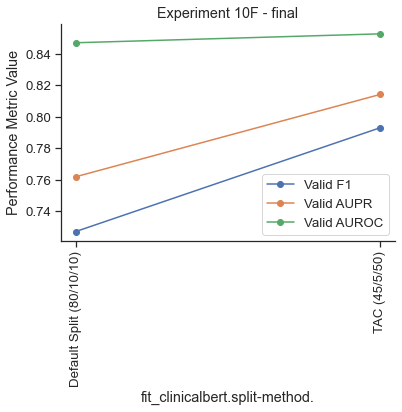

In [13]:
modeltype = 'final'
key = (modeltype, 'valid')
dfdata = {
    'Factor': experiment['labels'],
    'Valid Precision': [d['max_f1_precision'] for d in perfdata[key]['prdata']],
    'Valid Recall': [d['max_f1_recall'] for d in perfdata[key]['prdata']],
    'Valid F1': [d['max_f1'] for d in perfdata[key]['prdata']],
    'Valid AUPR': [d['pr_auc'] for d in perfdata[key]['prdata']],
    'Valid AUROC': [d['roc_auc'] for d in perfdata[key]['rocdata']],
    'Threshold': [d['max_f1_threshold'] for d in perfdata[key]['prdata']]
}

valid = pd.DataFrame(dfdata)

key = (modeltype, 'test')
dfdata = {
#     'Factor': experiment['labels'],
    'Test Precision': [d['max_f1_precision'] for d in perfdata[key]['prdata']],
    'Test Recall': [d['max_f1_recall'] for d in perfdata[key]['prdata']],
    'Test F1': [d['max_f1'] for d in perfdata[key]['prdata']],
    'Test AUPR': [d['pr_auc'] for d in perfdata[key]['prdata']],
    'Test AUROC': [d['roc_auc'] for d in perfdata[key]['rocdata']],
}

test = pd.DataFrame(dfdata)

sns.set(style='ticks', font_scale=1.2)

for col in ('Valid F1', 'Valid AUPR', 'Valid AUROC'):
    plt.plot(valid[col], 'o-', label=col)

plt.xticks(ticks = range(len(valid)), labels = valid['Factor'], rotation=90)
plt.xlabel(experiment['factor'])
plt.ylabel('Performance Metric Value')
plt.title(f"Experiment {experiment_id} - {modeltype}")
plt.legend()
sns.despine()

plt.savefig(f'../figures/Experiment{experiment_id}-{modeltype}-summary-stats.pdf')

pd.concat([valid, test], axis=1)

In [9]:
for fn in experiment['epochperf']:
    df = pd.read_csv(os.path.join('..', fn))
    print(fn, np.argmin(df['valid_loss']))

./results/epoch-results-CB2_14-BW-125-all_222_24_25_1e-05_256_32.csv 5
./results/epoch-results-CB2_14-BW-125-all_222_TAC_25_1e-05_256_32.csv 0
